In [1]:
import scanpy as sc
import numpy as np

In [2]:
adata = sc.read("/Volumes/kresna-ssd/data/zebrafish/23-08-29__scdata_75p_annotated__3d.h5ad")

In [3]:
genes = adata.var_names.str.capitalize().to_list()

In [4]:
import requests
import json

url = 'https://fisheyes.techkyra.com/savedata'
data = {'key': 'genes', 'value': json.dumps(genes)}

response = requests.post(url, json=data)
print(response.json())


{'message': 'Data saved to Redis under key: genes'}


In [3]:
adata = sc.read("./data/SVZMER.h5ad")

/opt/homebrew/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [7]:
x = adata.obsm["X_spatial"][:,0]
y = adata.obsm["X_spatial"][:,1]

In [8]:
import matplotlib.pyplot as plt

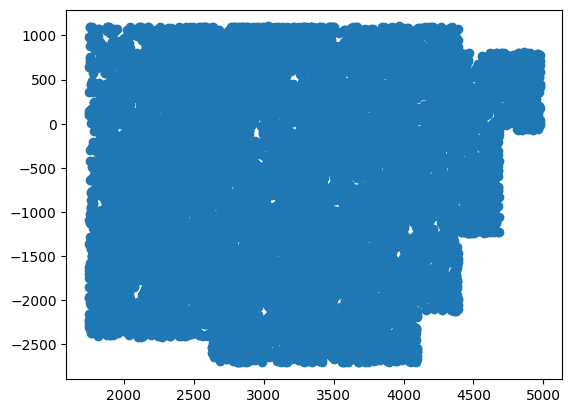

In [9]:
plt.scatter(x, y)

In [13]:
meanx = np.mean(x)
meany = np.mean(y)

(array([1941., 2205., 2169., 2158., 2147., 2042., 2180., 1800., 1152.,
         570.]),
 array([1751.34313965, 2073.72216797, 2396.10131836, 2718.48022461,
        3040.859375  , 3363.23852539, 3685.61743164, 4007.99658203,
        4330.37548828, 4652.75488281, 4975.13378906]),
 <BarContainer object of 10 artists>)

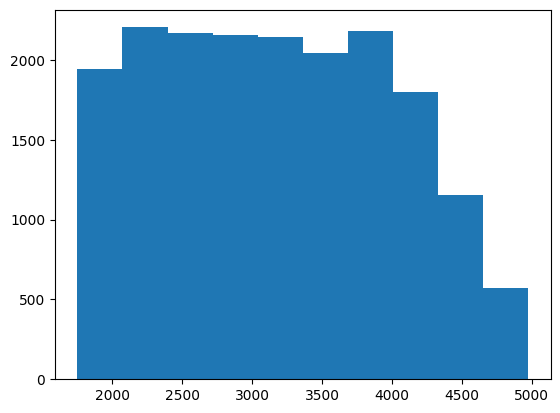

In [14]:
plt.hist(x)

In [15]:
nx = x-meanx

(array([1941., 2205., 2169., 2158., 2147., 2042., 2180., 1800., 1152.,
         570.]),
 array([-1421.46594238, -1099.08691406,  -776.70782471,  -454.32873535,
         -131.94967651,   190.42938232,   512.80847168,   835.1875    ,
         1157.56652832,  1479.94567871,  1802.32470703]),
 <BarContainer object of 10 artists>)

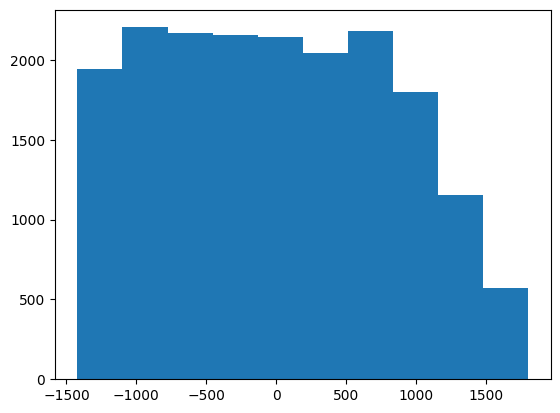

In [16]:
plt.hist(nx)

In [17]:
max(x)

4975.134

In [18]:
nnx = nx/((max(x)-min(x))/2)

(array([1941., 2205., 2169., 2158., 2147., 2042., 2180., 1800., 1152.,
         570.]),
 array([-0.88186002, -0.68186003, -0.48185998, -0.28185999, -0.08185997,
         0.11814004,  0.31814006,  0.51814008,  0.71814007,  0.91814011,
         1.1181401 ]),
 <BarContainer object of 10 artists>)

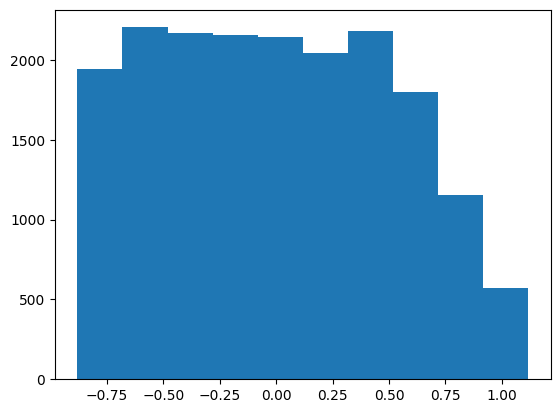

In [19]:
plt.hist(nnx)

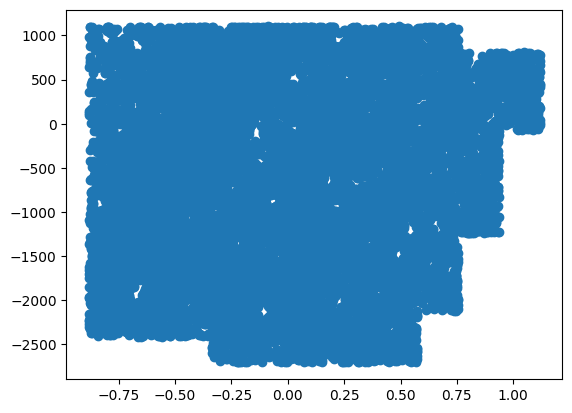

In [21]:
plt.scatter(nnx, y)

In [28]:
ny = (y-np.mean(y))

(array([1049., 1609., 1638., 1890., 2001., 1978., 2020., 2160., 2111.,
        1908.]),
 array([-2051.93457031, -1671.15087891, -1290.3671875 ,  -909.58349609,
         -528.79980469,  -148.01611328,   232.76757812,   613.55126953,
          994.33496094,  1375.11865234,  1755.90234375]),
 <BarContainer object of 10 artists>)

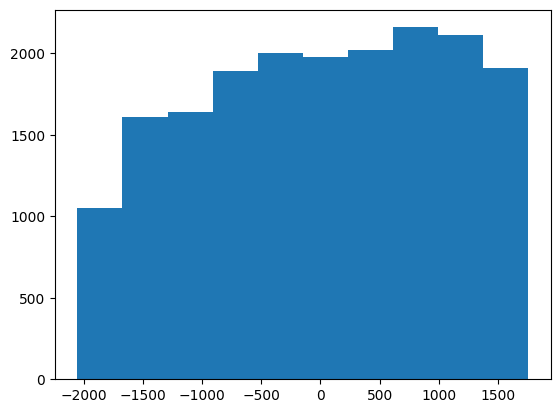

In [29]:
plt.hist(ny)

In [32]:
nny = ny/((max(x)-min(x))/2)

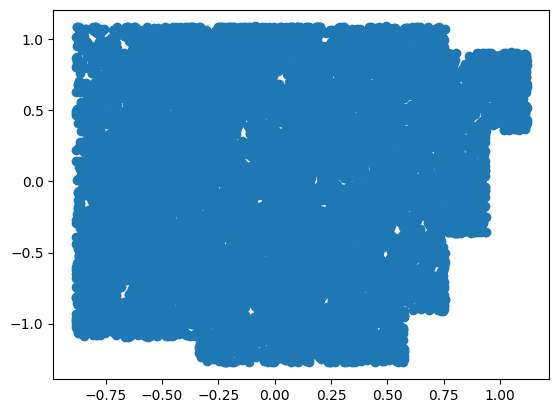

In [33]:
plt.scatter(nnx,nny)

In [69]:
adata = sc.read("./data/CBM2_new_immmature_dg.h5ad")

/opt/homebrew/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [70]:
x = adata.obsm["X_spatial"][:,0]
y = adata.obsm["X_spatial"][:,1]

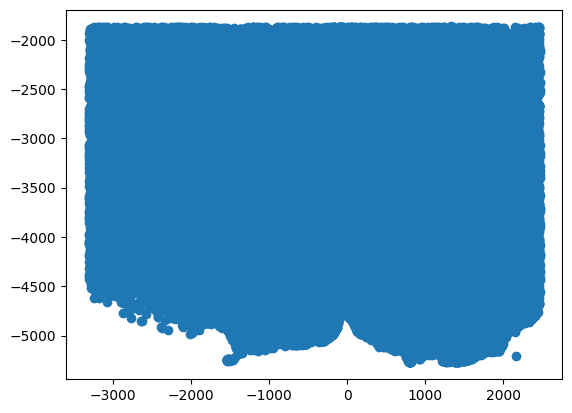

In [71]:
plt.scatter(x, y)

In [43]:
max(x)-min(x)

5779.281415369127

In [44]:
max(y)-min(y)

3407.59599958894

In [39]:
nx = (x-np.mean(x))/((max(x)-min(x))/2)
ny = (y-np.mean(y))/((max(x)-min(x))/2)

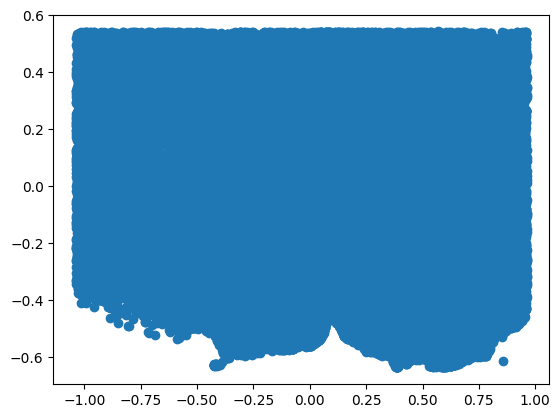

In [40]:
plt.scatter(nx, ny)

In [41]:
ny2 = (y-np.mean(y))/((max(y)-min(y))/2)

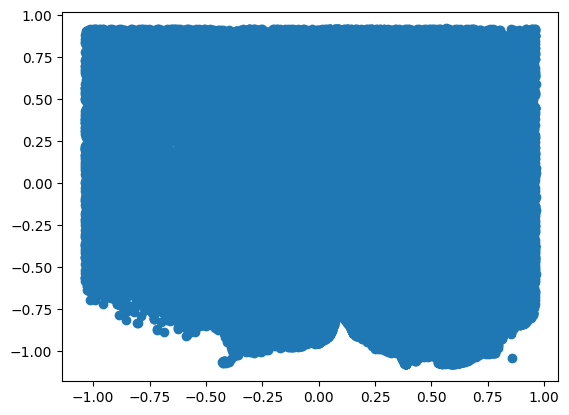

In [42]:
plt.scatter(nx, ny2)

In [95]:
import scanpy as sc
import pandas as pd
# import redis_test as re
from tqdm import tqdm
import json

def normalize(df, group, n_groups=1, interval=20):
    largest_delta = 0
    largest_group = f"{group}0"

    for x in range(n_groups):
        print(x)
        min_value = df[f"{group}{x}"].min()
        max_value = df[f"{group}{x}"].max()
        delta = max_value - min_value
        print(delta)
        if delta > largest_delta:
            largest_delta = delta
            largest_group = f"{group}{x}"
        print(largest_delta)

    # Calculate the current min and max values of the global_sphere1 column
    min_value = df[largest_group].min()
    max_value = df[largest_group].max()

    print(largest_group)

    for x in range(n_groups):
        df[f'{group}{x}_norm'] = ((df[f"{group}{x}"] - df[f"{group}{x}"].mean()) / (largest_delta/2))*interval/2

    
def parse_h5(adata):
    # convert adata to df (normalized values)
    df = adata.to_df()
    # add the obs in the df
    df = pd.concat([df, adata.obs], axis=1)

    # add the brain projection coordinates in the df
    for x in range(adata.obsm["X_spatial"].shape[1]):
        df[f"X_spatial{x}"] = adata.obsm["X_spatial"][:,x]

    # add the umap coordinates in the df
    # iterate through all axis if there's more than 2, it accounts for it
    for x in range(adata.obsm["X_umap"].shape[1]):
        df[f"X_umap{x}"] = adata.obsm["X_umap"][:,x]

    normalize(df, "X_spatial", n_groups=adata.obsm["X_spatial"].shape[1])

    # print(df["X_spatial0_norm"])
    # print(df["X_spatial1_norm"])

    # # save to redis norm + obs + umap + spatial
    # for col in tqdm(df):
    #     print(col)
    #     print()
    #     # re.save_to_redis(col, str(df[col].to_list()))
    #     re.save_to_redis(col, json.dumps(df[col].to_list()))
    #     # break

    # # convert adata to df (raw values)
    # df = pd.DataFrame(adata.obsm["X_raw"], columns=adata.to_df().columns, index=adata.obs.index)

    # # save to redis raw
    # for col in tqdm(df):
    #     re.save_to_redis(f"{col}_raw", json.dumps(df[col].to_list()))
    #     # break
    

    # # also save the uns for coloring purposes
    # re.save_to_redis("uns", str(adata.uns))
    return df

In [99]:
# adata = sc.read("./data/SVZMER.h5ad")
adata = sc.read("./data/CBM2_new_immmature_dg.h5ad")
df = parse_h5(adata)

0
5779.281415369127
5779.281415369127
1
3407.59599958894
5779.281415369127
X_spatial0


/opt/homebrew/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [100]:
df["X_spatial0_norm"].mean()

1.7303481188821171e-16

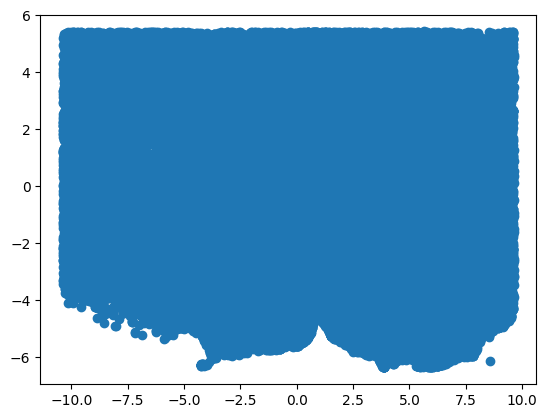

In [101]:
plt.scatter(df["X_spatial0_norm"], df["X_spatial1_norm"])

In [104]:
path = "./data/SVZMER.h5ad"
filename = path.split('/')[-1].split('.')[0]


In [105]:
filename

'SVZMER'

In [15]:
import pandas as pd

In [16]:
# convert adata to df (normalized values)
df = adata.to_df()
# add the obs in the df
df = pd.concat([df, adata.obs], axis=1)

# add the brain projection coordinates in the df
for x in range(adata.obsm["X_spatial"].shape[1]):
    df[f"X_spatial{x}"] = adata.obsm["X_spatial"][:,x]


In [20]:

df["X_spatial0"].max() - df["X_spatial0"].min()

3223.7905

In [21]:
adata.obsm["X_spatial"].shape[1]

2

In [60]:
def normalize(df, group, n_groups=1, new_min=-10, new_max=-10):
    largest_delta = 0
    largest_group = f"{group}0"

    for x in range(n_groups):
        min_value = df[f"{group}{x}"].min()
        max_value = df[f"{group}{x}"].max()
        delta = max_value - min_value
        print(delta)
        if delta > largest_delta:
            delta = largest_delta
            largest_group = f"{group}{x}"

    # Calculate the current min and max values of the global_sphere1 column
    min_value = df[largest_group].min()
    max_value = df[largest_group].max()

    print(largest_group)

    for x in range(n_groups):
        print(f"{group}{x}")
        print(df[f"{group}{x}"])
        df[f'{group}{x}_norm'] = ((df[f"{group}{x}"] - min_value) / (max_value - min_value)) * (new_max - new_min) + new_min

In [71]:
min_value = df["X_spatial1"].min()
max_value = df["X_spatial1"].max()
new_max = 10
new_min = -10

In [72]:
df['X_spatial0_norm'] = ((df['X_spatial0'] - min_value) / (max_value - min_value)) * (new_max - new_min) + new_min
df['X_spatial1_norm'] = ((df['X_spatial1'] - min_value) / (max_value - min_value)) * (new_max - new_min) + new_min


In [73]:
df

,AAAS,AARD,ABCB1,ABI3BP,ACAT2,ACTA1,ACTA2,ACTB,ACTC,ACTG1,...,blankmean,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,leiden,X_spatial0,X_spatial1,X_spatial0_norm,X_spatial1_norm
17600001,1.654202,0.0,0.0,0.721359,0.721359,1.136054,2.246841,0.0,0.000000,0.0,...,0.497069,621,6.432940,2712.609043,7.906035,12,1756.455444,-1969.305786,13.438526,-6.130387
17600002,1.609255,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.609255,0.0,...,0.405389,252,5.533389,717.125000,6.576644,7,1765.433105,-2047.503662,13.485678,-6.541108
17600003,0.000000,0.0,0.0,0.000000,0.000000,1.760426,2.106859,0.0,0.000000,0.0,...,0.445527,391,5.971262,1191.233156,7.083583,3,1765.115356,-2004.682007,13.484011,-6.316195
17600004,1.332764,0.0,0.0,0.000000,0.000000,2.237996,2.237996,0.0,0.000000,0.0,...,0.675568,420,6.042633,1027.345745,6.935707,4,1766.896484,-1949.360229,13.493366,-6.025626
17600005,0.937712,0.0,0.0,0.000000,0.000000,0.937712,1.733847,0.0,0.000000,0.0,...,0.385141,374,5.926926,1845.302305,7.520940,13,1782.750732,-1833.841187,13.576637,-5.418883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31100242,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.328584,78,4.369448,281.038121,5.642042,15,2012.520020,516.552307,14.783459,6.926149
31100243,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.396601,40,3.713572,47.007979,3.871367,15,2013.896973,724.509033,14.790689,8.018406
31100244,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.296561,111,4.718499,162.019504,5.093870,16,2022.668823,675.599609,14.836765,7.761518
31100246,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.182907,30,3.433987,76.005319,4.343874,15,2028.008789,542.113403,14.864811,7.060406


In [53]:
import matplotlib.pyplot as plt

(array([1941., 2205., 2169., 2158., 2147., 2042., 2180., 1800., 1152.,
         570.]),
 array([13.41167259, 15.10491276, 16.79815292, 18.49139214, 20.18463135,
        21.87787247, 23.57111168, 25.26435089, 26.9575901 , 28.65083122,
        30.34407043]),
 <BarContainer object of 10 artists>)

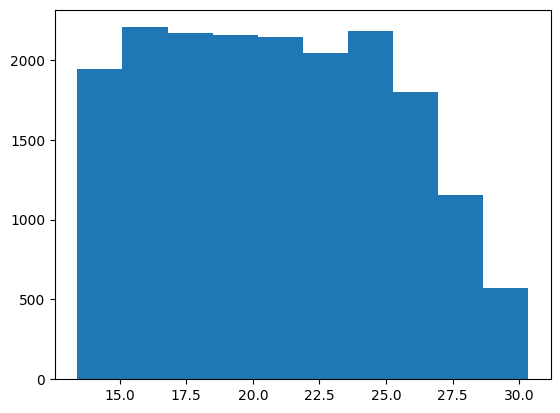

In [54]:
plt.hist(df["X_spatial0_norm"])

(array([1049., 1609., 1638., 1890., 2001., 1978., 2020., 2160., 2111.,
        1908.]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 <BarContainer object of 10 artists>)

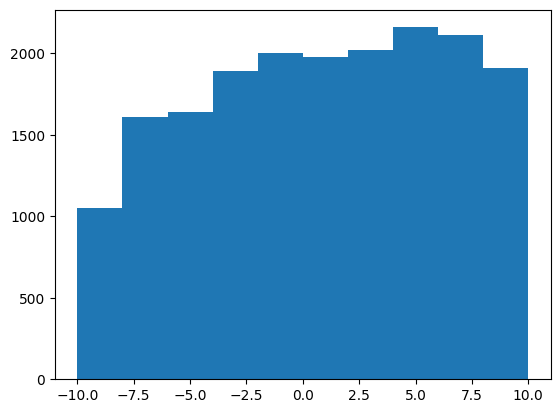

In [56]:
plt.hist(df["X_spatial1_norm"])


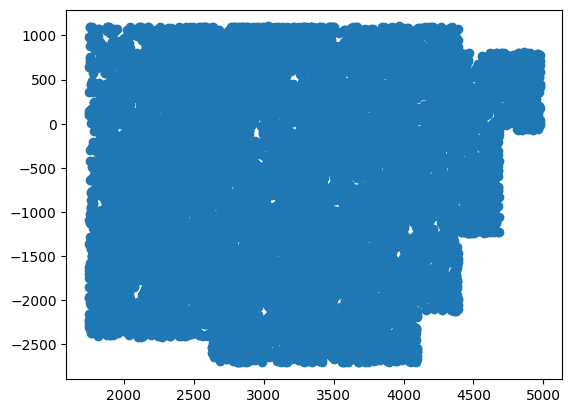

In [57]:
plt.scatter(df["X_spatial0"], df["X_spatial1"])

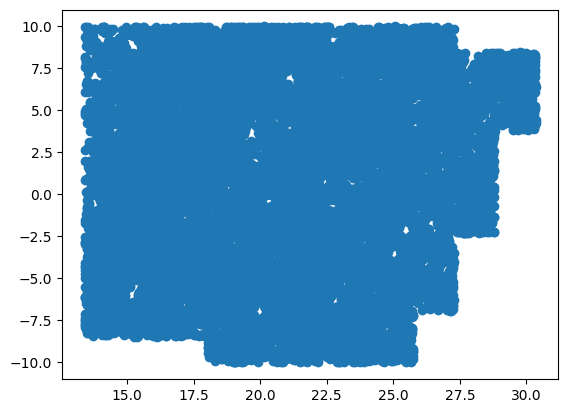

In [74]:
plt.scatter(df["X_spatial0_norm"], df["X_spatial1_norm"])

In [63]:
df["X_spatial0"].min()
df["X_spatial0"].max()

4975.134

In [65]:
print(df["X_spatial1"].min())
df["X_spatial1"].max()

-2706.0486


1101.7885

In [66]:

df["X_spatial1"].max() - df["X_spatial1"].min()


3807.837

In [67]:

df["X_spatial0"].max() - df["X_spatial0"].min()


3223.7905

In [61]:
normalize(df, "X_spatial", n_groups=2)

3223.7905
3807.837
X_spatial1
X_spatial0
17600001    1756.455444
17600002    1765.433105
17600003    1765.115356
17600004    1766.896484
17600005    1782.750732
               ...     
31100242    2012.520020
31100243    2013.896973
31100244    2022.668823
31100246    2028.008789
31100251    2042.958252
Name: X_spatial0, Length: 18364, dtype: float32
X_spatial1
17600001   -1969.305786
17600002   -2047.503662
17600003   -2004.682007
17600004   -1949.360229
17600005   -1833.841187
               ...     
31100242     516.552307
31100243     724.509033
31100244     675.599609
31100246     542.113403
31100251     687.919067
Name: X_spatial1, Length: 18364, dtype: float32
